In [4]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 194kB 8.1MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 


In [5]:
# all_slow

In [6]:
import os
import pandas as pd
import fastai
from fastai.vision.all import *

In [7]:
# Dataset pokemons
!git clone https://gitlab.enseeiht.fr/nurbani/dataset-pokemon

Cloning into 'dataset-pokemon'...
remote: Counting objects: 26364, done.
remote: Compressing objects: 100% (25090/25090), done.
remote: Total 26364 (delta 1274), reused 26364 (delta 1274)
Receiving objects: 100% (26364/26364), 26.87 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (1274/1274), done.


### Scanning all the data

In [8]:
data_path = 'data'
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk('dataset-pokemon') for f in filenames if os.path.splitext(f)[1] == '.png']

### Putting all data paths in one dataframe

In [9]:
df_data = pd.DataFrame(columns=['fname', 'labels', 'is_valid'])
for idx, i in enumerate(all_files):
    if '5G' not in i:
        df_data.loc[idx, 'fname'] = i
        if ('png' in i):
            i = i.replace('\\', '/').split('/')
            image_id = i[-1].split('.png')[0].split('-')[0][:3]
            if (image_id.isdigit()) and (int(image_id) <= 151):
                df_data.loc[idx, 'labels'] = image_id
            
df_data = df_data.dropna(subset=['labels'])
df_data['is_valid'] = [True if ('4G-platinum' in i) else False for i in df_data['fname']]

### Replacing labels by real pokemon names (in french)

In [11]:
df_names = pd.read_csv('pokemon.csv', header=None).reset_index().rename(columns={'index': 'id', 1: 'name'})
df_names['id'] += 1
df_names['id'] = df_names['id'].astype(str)
df_names = df_names.set_index('id')['name']
names_dict = df_names.to_dict()

df_data['labels'] = df_data['labels'].replace(names_dict)

### Showing few data instances: data = 1G to 4G. 4G-platinum = valid data, else is training data

In [12]:
print('number of training data:', df_data[df_data['is_valid'] == False].shape[0])
print('number of validation data:', df_data[df_data['is_valid']].shape[0])

df_data.sample(10)

number of training data: 8155
number of validation data: 1380


,fname,labels,is_valid
11069,dataset-pokemon/3G-firered-leafgreen/132.png,Métamorph,False
4603,dataset-pokemon/2G-crystal/115.png,Kangourex,False
24215,dataset-pokemon/4G-diamond-pearl/frame2/69.png,Chétiflor,False
5900,dataset-pokemon/1G-yellow/back/87.png,Lamantine,False
24327,dataset-pokemon/4G-diamond-pearl/frame2/26.png,Raichu,False
11874,dataset-pokemon/4G-heartgold-soulsilver/92.png,Fantominus,False
26088,dataset-pokemon/1G-red-green/55.png,Akwakwak,False
1285,dataset-pokemon/3G-ruby-sapphire/back/shiny/122.png,Mr.Mime,False
20874,dataset-pokemon/4G-platinum/back/shiny/female/frame2/119.png,Poissoroy,True
5428,dataset-pokemon/2G-crystal/back/shiny/131.png,Lokhlass,False


### Loading the data to the fastai ImageDataLoaders

In [13]:
dls = ImageDataLoaders.from_df(df_data, valid_col='is_valid', label_delim=' ', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224), num_workers=0)

### Showing input data examples

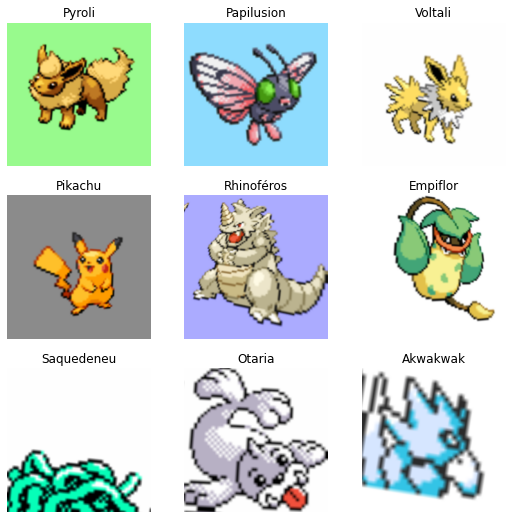

In [27]:
dls.show_batch()

### Loading a pre-trained resnet50

In [15]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5), path='D:/Projects/pokemon/resnet50-19c8e357.pth')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### Searching for the best learning rate

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.033113110810518265)

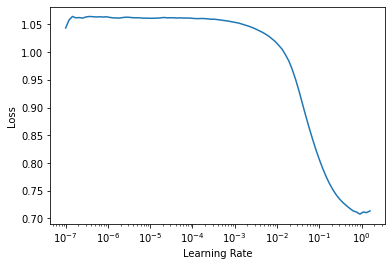

In [16]:
learn.lr_find()

### Setting the best learning rate

In [17]:
learn.fine_tune(2, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.124814,0.028452,0.993857,01:59


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.021946,0.013972,0.995652,02:22
1,0.007047,0.001598,0.999535,02:22


### Showing some results

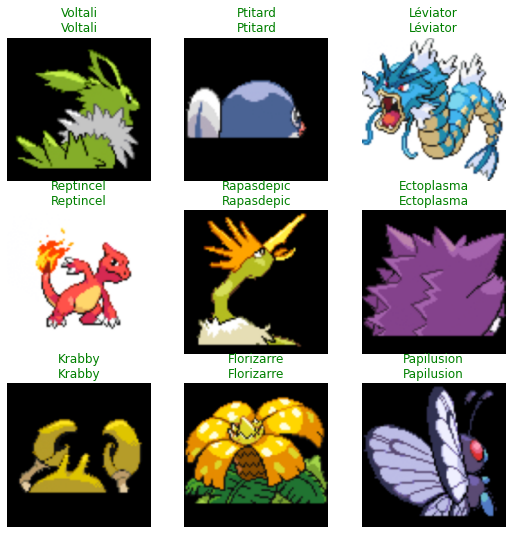

In [18]:
learn.show_results()

### Looking at the worse errors

,target,predicted,probabilities,loss
0,Ponyta,,"tensor([5.0894e-06, 2.5971e-05, 1.1585e-05, 6.5329e-04, 1.3537e-04, 5.8930e-06,\n 1.8060e-06, 5.1872e-03, 7.8042e-05, 8.7060e-06, 9.8439e-04, 8.3473e-05,\n 1.7612e-06, 1.7148e-06, 2.3702e-06, 2.8990e-07, 1.1751e-04, 2.8996e-07,\n 6.4510e-07, 2.3006e-07, 9.9890e-04, 5.9864e-06, 2.9040e-06, 2.8292e-05,\n 1.7840e-04, 3.0086e-06, 3.2208e-06, 2.4716e-06, 3.5325e-03, 2.8071e-05,\n 2.6238e-05, 3.4674e-05, 5.2498e-06, 2.3119e-06, 6.7664e-06, 1.2798e-05,\n 2.6876e-04, 1.9862e-05, 1.4399e-04, 6.5696e-03, 2.1806e-06, 3.2939e-06,\n 2.0716e-05, 1.6230e-02, 2.0768e-03, 5.0059e-06, 3.8996e-07, 5.2903e-07,\n 5.7451e-04, 1.0195e-05, 1.1202e-04, 1.8289e-05, 1.5283e-06, 5.0071e-06,\n 3.1969e-06, 4.7829e-06, 1.9912e-05, 1.6245e-05, 3.3352e-05, 5.0962e-05,\n 9.6970e-06, 1.0534e-05, 3.4693e-03, 1.5833e-04, 7.4521e-06, 3.0844e-03,\n 1.5651e-06, 2.5483e-05, 7.7963e-06, 6.7354e-06, 3.6072e-06, 2.8831e-05,\n 2.4941e-08, 2.3931e-06, 3.0395e-05, 8.4693e-05, 3.0575e-07, 5.6171e-07,\n 3.3581e-03, 1.7429e-07, 1.0965e-06, 8.3145e-05, 8.3829e-06, 2.0634e-04,\n 1.6292e-05, 2.9119e-05, 2.0291e-06, 8.7642e-06, 9.6672e-05, 1.0795e-06,\n 2.8524e-07, 8.5786e-06, 1.2868e-04, 3.3066e-05, 3.2974e-06, 3.3011e-04,\n 1.3290e-05, 7.2174e-05, 3.9443e-06, 2.4880e-07, 6.5562e-04, 3.1473e-05,\n 4.3223e-06, 2.1348e-03, 9.4462e-04, 2.5361e-05, 4.6487e-02, 3.7355e-06,\n 1.6493e-05, 5.7039e-07, 2.9505e-04, 1.1226e-02, 5.9714e-06, 1.8762e-06,\n 2.6227e-04, 2.4004e-05, 4.0762e-04, 1.3919e-06, 1.9969e-07, 4.6737e-02,\n 1.2744e-05, 6.3031e-06, 2.3610e-06, 8.7760e-05, 5.6638e-04, 2.8832e-04,\n 3.8952e-05, 4.0453e-05, 3.5008e-05, 1.9819e-04, 4.6186e-07, 2.8605e-05,\n 1.1904e-05, 4.7008e-05, 5.3598e-05, 5.9815e-05, 1.0925e-04, 6.9605e-07,\n 1.9421e-02, 9.0336e-05, 6.9387e-06, 1.1113e-06, 4.0593e-05, 1.0752e-05,\n 4.1529e-06, 1.2452e-06, 1.8488e-06, 6.5459e-07, 1.5258e-05, 1.0649e-04,\n 3.5051e-05])",0.021218324080109596
1,Aquali,,"tensor([1.0185e-03, 3.5634e-05, 5.5061e-06, 4.8255e-04, 7.9324e-05, 2.0867e-05,\n 1.0867e-05, 8.3614e-02, 4.7024e-04, 2.1157e-07, 1.1923e-05, 2.4147e-02,\n 1.0988e-05, 2.4823e-03, 1.7130e-04, 4.6540e-06, 6.5043e-05, 3.0082e-03,\n 1.3558e-05, 4.4541e-05, 4.2722e-03, 7.1935e-05, 9.3134e-06, 2.1476e-06,\n 2.1771e-04, 4.7919e-05, 3.1635e-06, 1.1379e-05, 4.9534e-06, 3.0309e-03,\n 1.7502e-05, 1.2218e-02, 2.6941e-06, 7.0255e-05, 8.2373e-06, 4.3114e-04,\n 2.1477e-01, 1.2048e-05, 8.4628e-04, 1.2490e-05, 7.6409e-06, 2.5769e-06,\n 1.2830e-05, 4.3843e-06, 4.2100e-05, 4.8790e-07, 2.8332e-03, 4.5783e-06,\n 2.3908e-05, 2.2189e-05, 2.2205e-04, 3.5829e-04, 6.2518e-04, 2.2463e-04,\n 1.0943e-04, 4.8433e-06, 1.0056e-05, 6.0730e-06, 6.6817e-05, 2.7647e-04,\n 1.4485e-06, 1.1227e-05, 7.9542e-05, 1.5905e-05, 1.9147e-06, 1.1236e-05,\n 5.5088e-06, 3.9935e-05, 1.0548e-05, 6.5440e-06, 1.9906e-05, 6.7336e-06,\n 4.3957e-06, 3.9115e-06, 5.4471e-05, 7.5004e-06, 1.4527e-05, 4.1334e-05,\n 1.5191e-02, 1.9574e-07, 3.3160e-03, 1.5670e-04, 4.8023e-05, 6.9500e-06,\n 6.9147e-05, 6.4247e-04, 6.0746e-05, 1.7332e-04, 5.2097e-05, 1.8928e-05,\n 1.0655e-05, 9.5192e-04, 1.5035e-03, 5.1090e-05, 4.4078e-05, 3.3398e-04,\n 5.4903e-04, 1.0640e-04, 2.1390e-04, 8.3547e-07, 1.5556e-05, 4.8823e-06,\n 8.4931e-05, 9.7781e-03, 1.1472e-04, 2.2500e-04, 6.8477e-05, 1.0154e-03,\n 2.5534e-04, 4.0922e-04, 1.1532e-04, 1.9395e-02, 2.8568e-06, 3.0883e-04,\n 8.2221e-03, 3.4119e-04, 4.7347e-06, 2.9537e-06, 1.2606e-07, 3.9027e-04,\n 3.6115e-07, 1.0648e-05, 2.3742e-03, 1.7916e-03, 4.2666e-06, 8.5455e-06,\n 4.7183e-06, 1.2262e-04, 2.7092e-05, 1.6566e-05, 8.9207e-06, 2.3567e-05,\n 2.9095e-06, 3.7887e-06, 2.3061e-05, 1.8789e-04, 3.6972e-04, 1.9497e-05,\n 6.4686e-06, 7.7785e-05, 2.1652e-05, 1.6225e-05, 3.7681e-05, 2.5107e-04,\n 2.9805e-06, 6.5533e-06, 3.7726e-06, 8.1179e-05, 3.1738e-05, 4.6981e-03,\n 2.0529e-03])",0.018935421481728554
2,Aquali,,"tensor([9.0441e-04, 5.9205e-06, 1.3632e-06, 3.4853e-04, 8.9822e-06, 6.1035e-05,\n 3.0169e-05, 7.0837e-02, 1.7173e-04, 3.8682e-07, 2.7551e-05, 6.

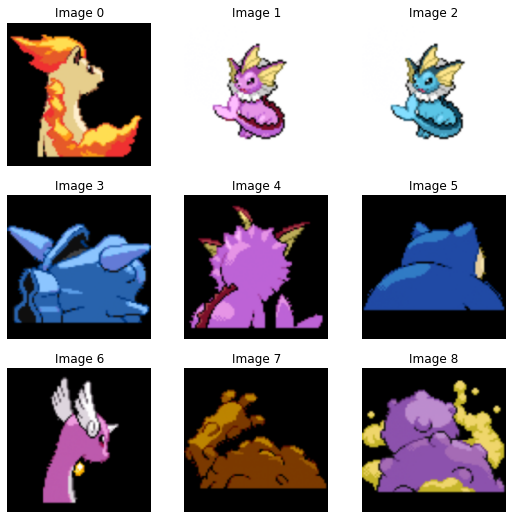

In [19]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

### Loading test set

In [20]:
df_data_test = pd.DataFrame(columns=['fname', 'labels'])
for idx, i in enumerate(all_files):
    if '5G' in i:
        df_data_test.loc[idx, 'fname'] = i
        if ('png' in i):
            i = i.replace('\\', '/').split('/')
            image_id = i[-1].split('.png')[0].split('-')[0][:3]
            if (image_id.isdigit()) and (int(image_id) <= 151):
                df_data_test.loc[idx, 'labels'] = image_id
            
df_data_test = df_data_test.dropna(subset=['labels'])
df_data_test['labels'] = df_data_test['labels'].replace(names_dict)

df_data_test = df_data_test.reset_index().drop(columns=['index'])

print('number of images in test set:', len(df_data_test))

number of images in test set: 694


### Ensuring we are actually looking at the test set

In [21]:
df_data_test.sample(10)

,fname,labels
380,dataset-pokemon/5G-black-white/back/142.png,Ptéra
426,dataset-pokemon/5G-black-white/back/28.png,Sablaireau
115,dataset-pokemon/5G-black-white/123.png,Insécateur
158,dataset-pokemon/5G-black-white/female/118.png,Poissirène
272,dataset-pokemon/5G-black-white/shiny/76.png,Grolem
589,dataset-pokemon/5G-black-white/back/shiny/129.png,Magicarpe
48,dataset-pokemon/5G-black-white/135.png,Voltali
12,dataset-pokemon/5G-black-white/121.png,Staross
630,dataset-pokemon/5G-black-white/back/shiny/132.png,Métamorph
106,dataset-pokemon/5G-black-white/47.png,Parasect


### Loading the test set

In [22]:
p = Pipeline([ColReader('fname'), PILImage.create])
dls.valid_ds.tls[0].tfms = p
dls.valid_ds.tls[0].types.insert(0, pd.Series)
f = test_set(dls.valid_ds, df_data_test, with_labels=True)

In [23]:
df_data.head(10)

,fname,labels,is_valid
0,dataset-pokemon/3G-ruby-sapphire/46.png,Paras,False
2,dataset-pokemon/3G-ruby-sapphire/58.png,Caninos,False
5,dataset-pokemon/3G-ruby-sapphire/60.png,Ptitard,False
6,dataset-pokemon/3G-ruby-sapphire/9.png,Tortank,False
7,dataset-pokemon/3G-ruby-sapphire/136.png,Pyroli,False
8,dataset-pokemon/3G-ruby-sapphire/38.png,Feunard,False
9,dataset-pokemon/3G-ruby-sapphire/13.png,Aspicot,False
13,dataset-pokemon/3G-ruby-sapphire/67.png,Machopeur,False
15,dataset-pokemon/3G-ruby-sapphire/62.png,Tartard,False
17,dataset-pokemon/3G-ruby-sapphire/59.png,Arcanin,False


### Performing perdictions

In [24]:
from IPython import display
display.display(loaded_image)

NameError: ignored

----------
15 WRONG! Prediction: Nidoran? Actual: Nosferapti


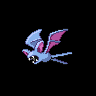

----------


----------
25 WRONG! Prediction: Psykokwak Actual: Smogo


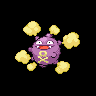

----------


----------
63 WRONG! Prediction: Nidoran? Actual: Nidorino


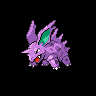

----------


----------
81 WRONG! Prediction: Nidoran? Actual: Nidorina


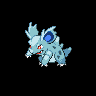

----------


----------
97 WRONG! Prediction: Roucool Actual: Roucoups


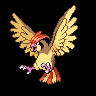

----------


----------
119 WRONG! Prediction: Ptitard Actual: Tétarte


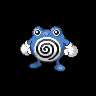

----------


----------
125 WRONG! Prediction: Electrode Actual: 0


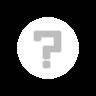

----------


----------
153 WRONG! Prediction: Nidoran? Actual: Nosferapti


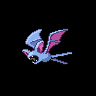

----------


----------
203 WRONG! Prediction: Tortank Actual: Flagadoss


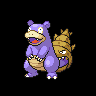

----------


----------
255 WRONG! Prediction: Nidoran? Actual: Nidorina


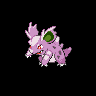

----------


----------
271 WRONG! Prediction: Roucool Actual: Roucoups


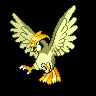

----------


----------
299 WRONG! Prediction: Electrode Actual: 0


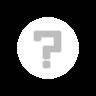

----------


----------
327 WRONG! Prediction: Mystherbe Actual: Nosferapti


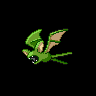

----------


----------
349 WRONG! Prediction: Noeunoeuf Actual: Caninos


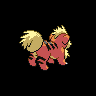

----------


----------
356 WRONG! Prediction: Tétarte Actual: Tartard


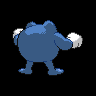

----------


----------
358 WRONG! Prediction: Scarabrute Actual: Mackogneur


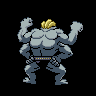

----------


----------
366 WRONG! Prediction: Taupiqueur Actual: Psykokwak


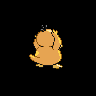

----------


----------
373 WRONG! Prediction: Magneti Actual: Smogo


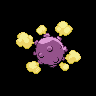

----------


----------
379 WRONG! Prediction: Rondoudou Actual: Lamantine


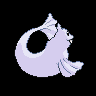

----------


----------
380 WRONG! Prediction: Nosferapti Actual: Ptéra


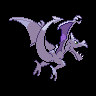

----------


----------
391 WRONG! Prediction: Reptincel Actual: Dracaufeu


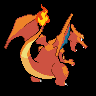

----------


----------
392 WRONG! Prediction: Tadmorv Actual: Grotadmorv


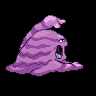

----------


----------
396 WRONG! Prediction: Roucool Actual: Voltali


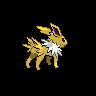

----------


----------
397 WRONG! Prediction: Hypocéan Actual: Nidoqueen


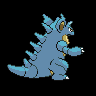

----------


----------
403 WRONG! Prediction: Sabelette Actual: Kokiyas


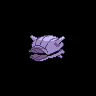

----------


----------
405 WRONG! Prediction: Amonita Actual: Amonistar


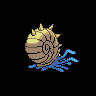

----------


----------
415 WRONG! Prediction: Aéromite Actual: Papilusion


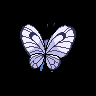

----------


----------
421 WRONG! Prediction: Roucool Actual: Evoli


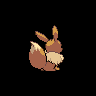

----------


----------
425 WRONG! Prediction: Magneti Actual: Magneton


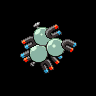

----------


----------
426 WRONG! Prediction: Sabelette Actual: Sablaireau


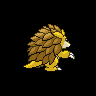

----------


----------
427 WRONG! Prediction: Aspicot Actual: Pikachu


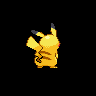

----------


----------
428 WRONG! Prediction: Abo Actual: Arbok


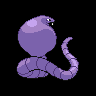

----------


----------
429 WRONG! Prediction: Nidoran? Actual: Nidorina


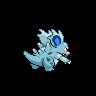

----------


----------
433 WRONG! Prediction: Taupiqueur Actual: Triopikeur


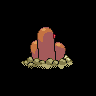

----------


----------
438 WRONG! Prediction: Hypotrempe Actual: Aquali


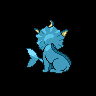

----------


----------
445 WRONG! Prediction: Roucool Actual: Roucoups


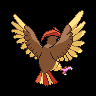

----------


----------
450 WRONG! Prediction: Sulfura Actual: Galopa


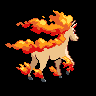

----------


----------
455 WRONG! Prediction: Magneti Actual: Hypotrempe


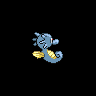

----------


----------
458 WRONG! Prediction: Osselait Actual: Ossatueur


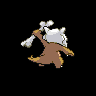

----------


----------
469 WRONG! Prediction: Roucool Actual: Osselait


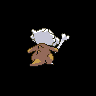

----------


----------
473 WRONG! Prediction: Electrode Actual: 0


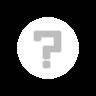

----------


----------
479 WRONG! Prediction: Ectoplasma Actual: Spectrum


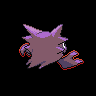

----------


----------
481 WRONG! Prediction: Chenipan Actual: Abra


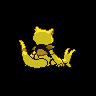

----------


----------
491 WRONG! Prediction: Ramoloss Actual: Excelangue


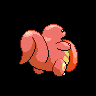

----------


----------
496 WRONG! Prediction: Caninos Actual: Soporifik


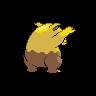

----------


----------
498 WRONG! Prediction: Hypocéan Actual: Akwakwak


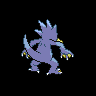

----------


----------
504 WRONG! Prediction: Alakazam Actual: Kadabra


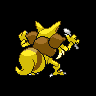

----------


----------
509 WRONG! Prediction: Aéromite Actual: Papilusion


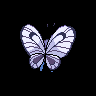

----------


----------
512 WRONG! Prediction: Aspicot Actual: Pikachu


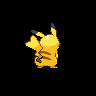

----------


----------
524 WRONG! Prediction: Onix Actual: Tortank


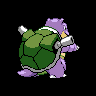

----------


----------
531 WRONG! Prediction: Grolem Actual: Mackogneur


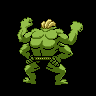

----------


----------
537 WRONG! Prediction: Racaillou Actual: Noeunoeuf


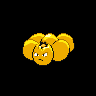

----------


----------
539 WRONG! Prediction: Métamorph Actual: Psykokwak


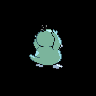

----------


----------
550 WRONG! Prediction: Gravalanch Actual: Flagadoss


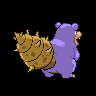

----------


----------
551 WRONG! Prediction: Paras Actual: Chétiflor


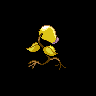

----------


----------
554 WRONG! Prediction: Electrode Actual: Leveinard


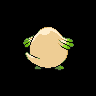

----------


----------
565 WRONG! Prediction: Tadmorv Actual: Grotadmorv


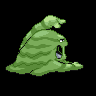

----------


----------
566 WRONG! Prediction: Voltorbe Actual: Kabuto


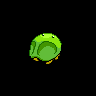

----------


----------
570 WRONG! Prediction: Rhinoféros Actual: Nidoqueen


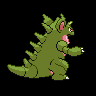

----------


----------
574 WRONG! Prediction: Coconfort Actual: Chenipan


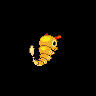

----------


----------
576 WRONG! Prediction: Sabelette Actual: Kokiyas


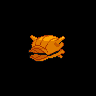

----------


----------
578 WRONG! Prediction: Amonita Actual: Amonistar


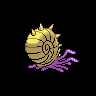

----------


----------
588 WRONG! Prediction: Aéromite Actual: Papilusion


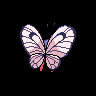

----------


----------
592 WRONG! Prediction: Tadmorv Actual: Lokhlass


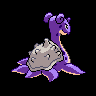

----------


----------
594 WRONG! Prediction: Minidraco Actual: Evoli


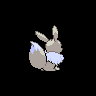

----------


----------
598 WRONG! Prediction: Magneti Actual: Magneton


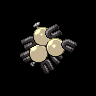

----------


----------
599 WRONG! Prediction: Sabelette Actual: Sablaireau


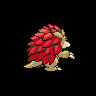

----------


----------
601 WRONG! Prediction: Abo Actual: Arbok


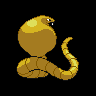

----------


----------
602 WRONG! Prediction: Nidoran? Actual: Nidorina


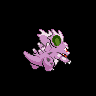

----------


----------
603 WRONG! Prediction: Mew Actual: Abo


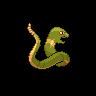

----------


----------
606 WRONG! Prediction: Taupiqueur Actual: Triopikeur


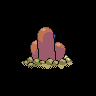

----------


----------
611 WRONG! Prediction: Hypotrempe Actual: Aquali


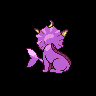

----------


----------
618 WRONG! Prediction: Rapasdepic Actual: Roucoups


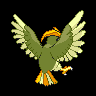

----------


----------
628 WRONG! Prediction: Porygon Actual: Hypotrempe


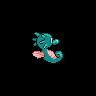

----------


----------
631 WRONG! Prediction: Osselait Actual: Ossatueur


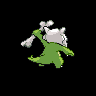

----------


----------
640 WRONG! Prediction: Métamorph Actual: Tétarte


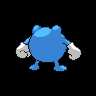

----------


----------
642 WRONG! Prediction: Nidoran? Actual: Osselait


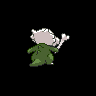

----------


----------
646 WRONG! Prediction: Electrode Actual: 0


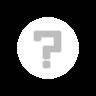

----------


----------
650 WRONG! Prediction: Evoli Actual: Grodoudou


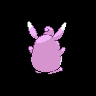

----------


----------
652 WRONG! Prediction: Ectoplasma Actual: Spectrum


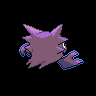

----------


----------
654 WRONG! Prediction: Aspicot Actual: Abra


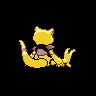

----------


----------
664 WRONG! Prediction: Racaillou Actual: Excelangue


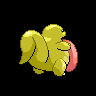

----------


----------
671 WRONG! Prediction: Hypocéan Actual: Akwakwak


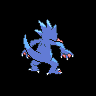

----------


----------
672 WRONG! Prediction: Minidraco Actual: Draco


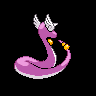

----------


----------
677 WRONG! Prediction: Alakazam Actual: Kadabra


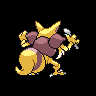

----------


----------
682 WRONG! Prediction: Aéromite Actual: Papilusion


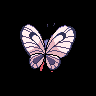

----------


In [25]:
predictions_binary = []
labels_list = dls.vocab
for idx, line in df_data_test.iterrows():
    
    pokemon_name = line['labels']
    
    loaded_image = f[idx][0]
    
    try:
        prediction_int = int(learn.predict(loaded_image)[2].argmax())
        prediction_name = labels_list[prediction_int]
    except IndexError:
        prediction = 'none'
        
    if prediction_name == pokemon_name:
        predictions_binary.append(1)
    else:
        print('----------')
        print(idx, 'WRONG! Prediction:', prediction_name, 'Actual:', pokemon_name)
        display.display(loaded_image)
        print('----------')
        predictions_binary.append(0)


### Compute accuracy on test set

In [28]:
test_acc = np.array(predictions_binary).sum()/len(predictions_binary)
print('test set accuracy:', test_acc.round(4))

test set accuracy: 0.8761
